# Traffic Light Detection Inference

Inference for pre-trained detection model

In [38]:
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util

%matplotlib inline

In [63]:
class TrafficLightClassifier(object):
    MIN_SCORE_THRESHOLD = 0.5 # Minimum score of a box for classification
    
    def __init__(self, frozen_model):
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            # Works up to here.
            with tf.gfile.GFile(frozen_model, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
            self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
            self.d_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
            self.d_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
            self.d_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
            self.num_d = self.detection_graph.get_tensor_by_name('num_detections:0')
        self.sess = tf.Session(graph=self.detection_graph)
        
    def get_classification(self, img):
        # Bounding Box Detection.
        with self.detection_graph.as_default():
            # Expand dimension since the model expects image to have shape [1, None, None, 3].
            img_expanded = np.expand_dims(img, axis=0)  
            (boxes, scores, classes, num_detections) = self.sess.run(
                [self.d_boxes, self.d_scores, self.d_classes, self.num_d],
                feed_dict={self.image_tensor: img_expanded})
            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
        return boxes, scores, classes, num_detections

In [64]:
model_sim_dir = "./models/rfcn_resnet101_coco_2018_01_28_sim"
model_real_dir = "./models/rfcn_resnet101_coco_2018_01_28_real"
frozen_model_suffix = "/fine_tuned_model/frozen_inference_graph.pb"
frozen_model_sim = model_sim_dir + frozen_model_suffix
frozen_model_real = model_real_dir + frozen_model_suffix
label_map_path = "./data/label_map.pbtxt"
max_num_classes = 4

In [65]:
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': u'Green'}, 2: {'id': 2, 'name': u'Red'}, 3: {'id': 3, 'name': u'Yellow'}, 4: {'id': 4, 'name': u'off'}}


In [66]:
def load_image(img_path):
    img = Image.open(img_path)
    w,h = img.size
    return np.array(img.getdata()).reshape(h, w, 3).astype(np.uint8)

In [73]:
def test_image(classifier, img):
    t0 = time.time()
    boxes, scores, classes, num_detections = classifier.get_classification(img)
    vis_util.visualize_boxes_and_labels_on_image_array(img, boxes, classes, scores,
                                                       category_index, use_normalized_coordinates=True,
                                                       line_thickness=5)
    time_taken = time.time() - t0
    print "Time of inference in ms: ", time_taken*1000
    plt.figure(figsize=(15, 8))
    plt.imshow(img)
    plt.show()

In [71]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

./test_images_real/left0358.jpg
Time of inference in ms:  6404.83903885


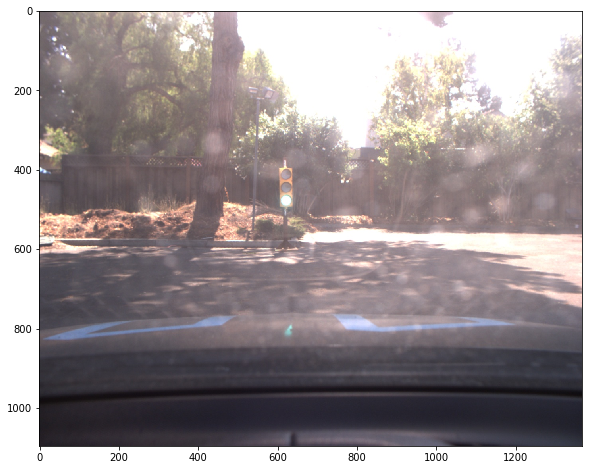

./test_images_real/left0282.jpg
Time of inference in ms:  2944.8299408


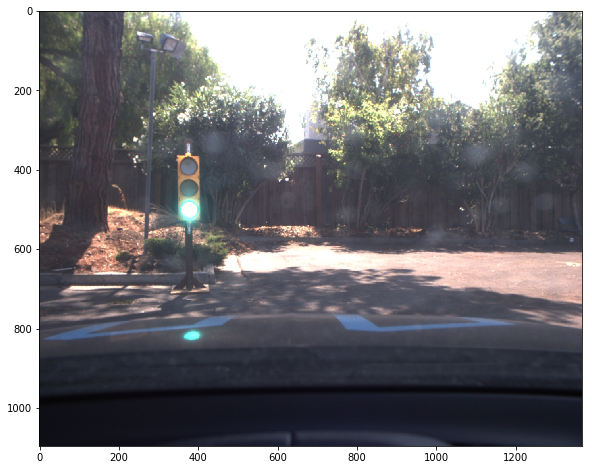

./test_images_real/left0681.jpg
Time of inference in ms:  2863.75784874


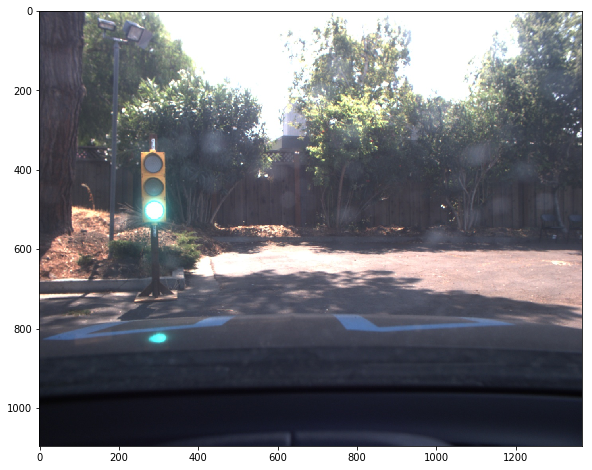

./test_images_real/left0561.jpg
Time of inference in ms:  2983.82806778


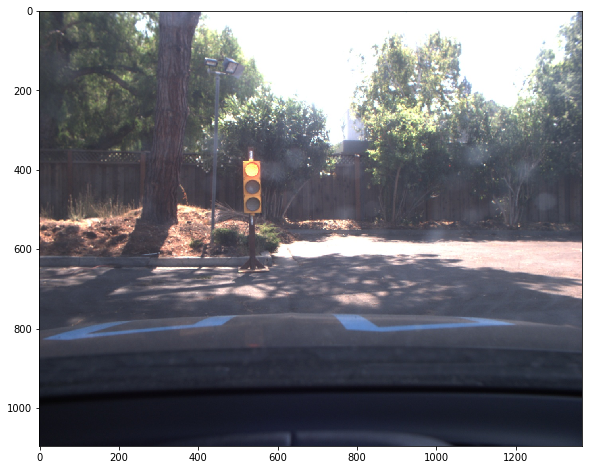

./test_images_real/left0701.jpg
Time of inference in ms:  2948.32801819


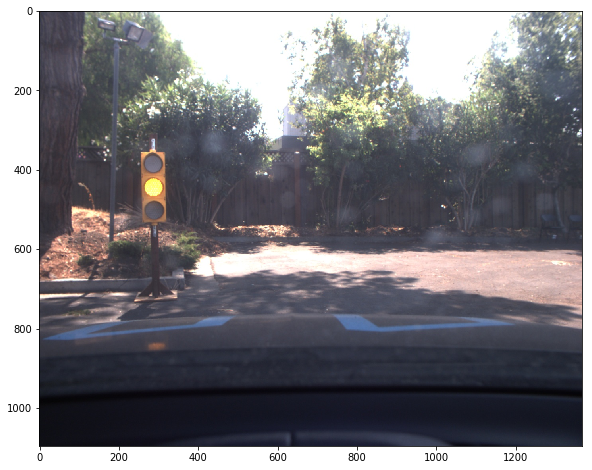

./test_images_real/left0140.jpg
Time of inference in ms:  3041.0349369


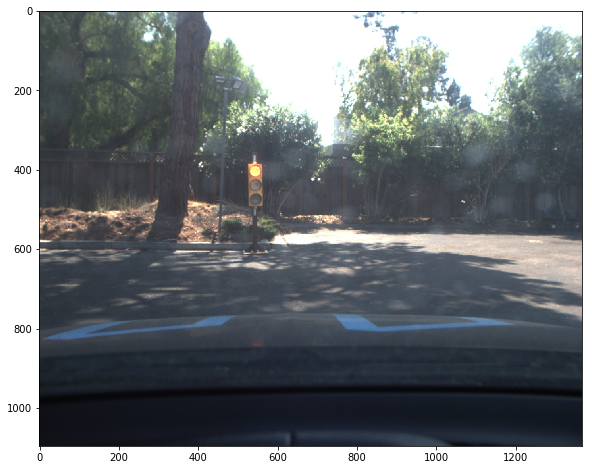

./test_images_real/left0528.jpg
Time of inference in ms:  3012.99715042


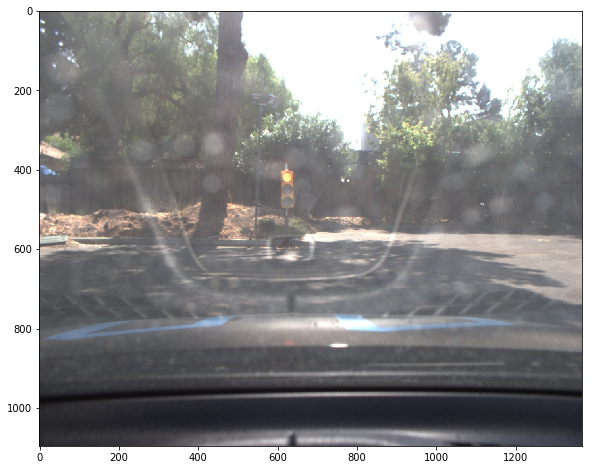

./test_images_real/left0183.jpg
Time of inference in ms:  2974.38287735


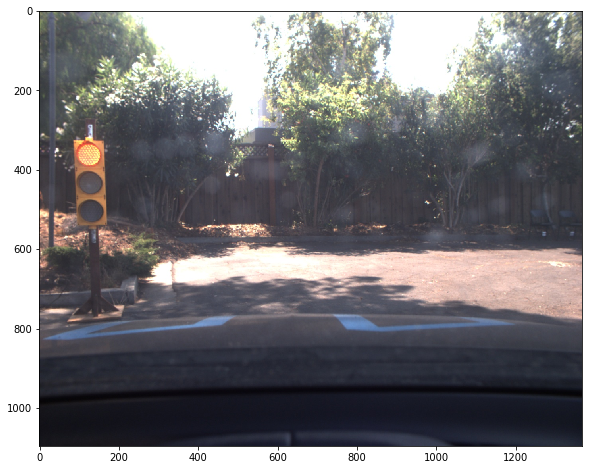

./test_images_real/left0000.jpg
Time of inference in ms:  3015.75517654


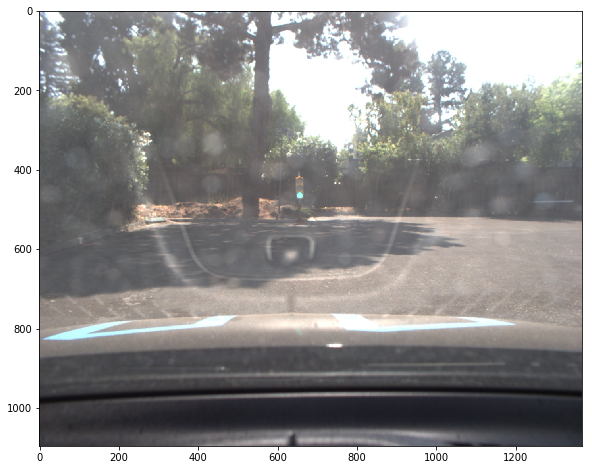

In [75]:
tlc_sim = TrafficLightClassifier(frozen_model_sim)
sim_images = glob.glob("./test_images_sim/left*.jpg")

for i in range(len(sim_images)):
    print(sim_images[i])
    img = load_image(sim_images[i])
    test_image(tlc_sim, img)